# Reduce Model Error by Using N-Components in PCA

Training a model with all ~26,000 genes is not feasible, and training on 50 PCA components generated from the entire gene set greatly increases the model error. Make a plot to associate the number of genes trained on with model error.

Summary: Transforming even just 200 genes down to 100 components drastically increases the model error. 

# Inputs

In [14]:
import rnaseq_lib3 as r

import pandas as pd
import pymc3 as pm
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Read in centered data
df = pd.read_hdf('/mnt/data/expression/tcga_gtex_tpm_norm_filt_centered.hd5')
# Subset
gtex = df[df.label == 'gtex'].sort_values('tissue')
normal = df[df.label == 'tcga-normal'].sort_values('tissue')
tumor = df[df.label == 'tcga-tumor'].sort_values('tissue')
# Read in drug genes
genes = df.columns[5:]
drug_genes = [x.split('\t')[0] for x in open('../data/druggable-genes.tsv', 'r').readlines()]
drug_genes = [x for x in drug_genes if x in df.columns]

In [30]:
def prepare_sample(df, sample, genes, n_genes, class_col='tissue', n_comp=100):
    # Select genes to use in dimensionality reduction
    training_genes = r.outlier.select_k_best_genes(df, genes, class_col, n=n_genes)
    
    # Add n-of-1 to dataframe 
    combined_df = df.append(sample)
    
    # Setup PCA
    X_genes = [f'Gene{x}' for x in range(n_comp)]
    pca = PCA(n_components=n_comp)
    X = pca.fit_transform(combined_df[genes])
    
    # Split out X/y back into DataFrame and Series
    y = pd.Series(X[-1, :], index=X_genes)

    X = X[:-1, :]
    X = pd.DataFrame(X, index=df.index)
    X.columns = X_genes
    
    # Add back in metadata
    for col in df.columns[:5]:
        X[col] = df[col]
        y[col] = sample[col]
    
    return X, y, X_genes

# Model Runs

- For each set of N genes
    - Run model
    - Save error
- Make plot

In [23]:
sample = tumor.loc['TCGA-KK-A7B2-01']
classes = normal.tissue.unique()
error_map = {}
pvals = {}

## Control (100 Genes)

In [7]:
training_genes = r.outlier.select_k_best_genes(normal, genes, 'tissue', n=100)

In [11]:
m, t = r.outlier.run_model(sample, normal, 'tissue', 
                           training_genes=training_genes,
                           beta_func=pm.LogitNormal)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [22:33<00:00,  2.35draws/s] 
The number of effective samples is smaller than 25% for some parameters.


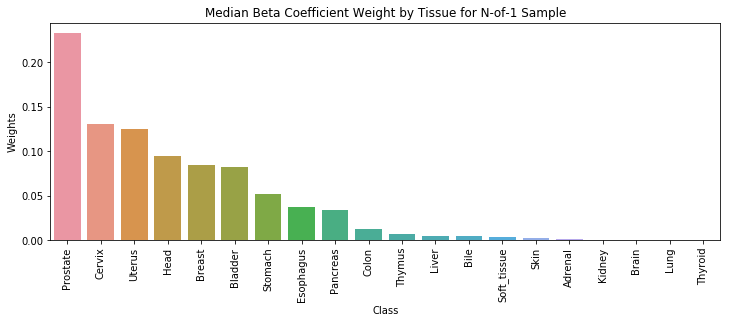

In [25]:
r.outlier.plot_weights(classes, t)

In [28]:
error_map[100] = t['eps']

ppc = r.outlier.ppc_from_coefs(t, drug_genes, normal, 'tissue')
pvals[100] = r.outlier.posterior_predictive_pvals(sample, ppc)

100%|██████████| 85/85 [02:36<00:00,  1.87s/it]


## 200 Genes

In [32]:
X, y, X_genes = prepare_sample(normal, sample, genes, n_genes=200, class_col='tissue', n_comp=100)

In [33]:
m, t = r.outlier.run_model(y, X, 'tissue', 
                           training_genes=X_genes,
                           beta_func=pm.LogitNormal)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [19:39<00:00,  1.95draws/s] 
The number of effective samples is smaller than 25% for some parameters.


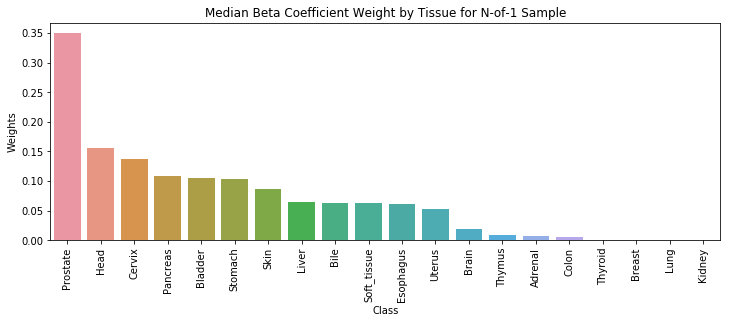

In [34]:
r.outlier.plot_weights(classes, t)

In [35]:
error_map[200] = t['eps']

ppc = r.outlier.ppc_from_coefs(t, drug_genes, normal, 'tissue')
pvals[200] = r.outlier.posterior_predictive_pvals(sample, ppc)

100%|██████████| 85/85 [02:34<00:00,  1.82s/it]


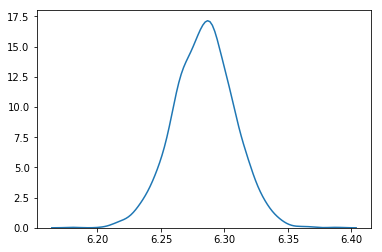

In [38]:
sns.kdeplot(error_map[200])

## 300 Genes

In [32]:
X, y, X_genes = prepare_sample(normal, sample, genes, n_genes=300, class_col='tissue', n_comp=100)

In [33]:
m, t = r.outlier.run_model(y, X, 'tissue', 
                           training_genes=X_genes,
                           beta_func=pm.LogitNormal)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [19:39<00:00,  1.95draws/s] 
The number of effective samples is smaller than 25% for some parameters.


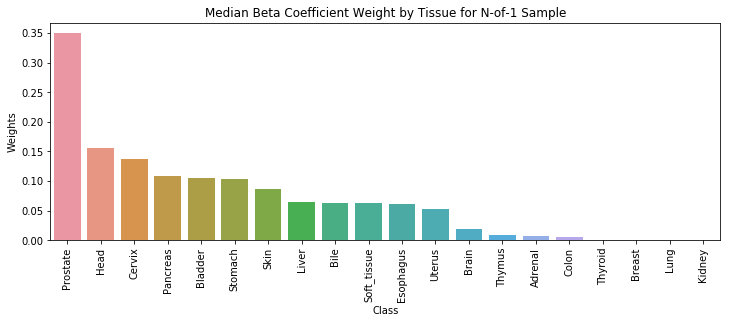

In [34]:
r.outlier.plot_weights(classes, t)

In [ ]:
error_map[300] = t['eps']

ppc = r.outlier.ppc_from_coefs(t, drug_genes, normal, 'tissue')
pvals[300] = r.outlier.posterior_predictive_pvals(sample, ppc)

 26%|██▌       | 130/500 [00:09<00:26, 13.80it/s]

## 400 Genes

In [32]:
X, y, X_genes = prepare_sample(normal, sample, genes, n_genes=400, class_col='tissue', n_comp=100)

In [33]:
m, t = r.outlier.run_model(y, X, 'tissue', 
                           training_genes=X_genes,
                           beta_func=pm.LogitNormal)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [19:39<00:00,  1.95draws/s] 
The number of effective samples is smaller than 25% for some parameters.


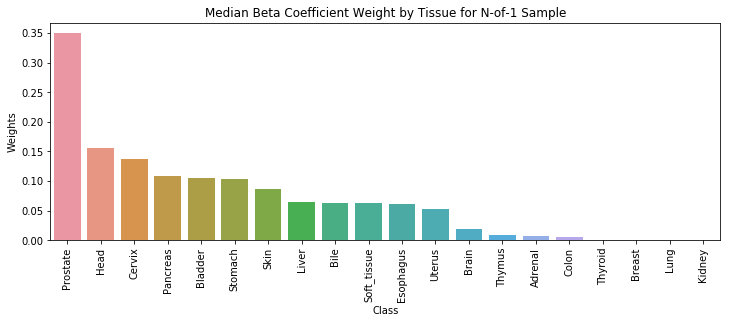

In [34]:
r.outlier.plot_weights(classes, t)

In [ ]:
error_map[400] = t['eps']

ppc = r.outlier.ppc_from_coefs(t, drug_genes, normal, 'tissue')
pvals[400] = r.outlier.posterior_predictive_pvals(sample, ppc)

 26%|██▌       | 130/500 [00:09<00:26, 13.80it/s]

## 500 Genes

In [32]:
X, y, X_genes = prepare_sample(normal, sample, genes, n_genes=500, class_col='tissue', n_comp=100)

In [33]:
m, t = r.outlier.run_model(y, X, 'tissue', 
                           training_genes=X_genes,
                           beta_func=pm.LogitNormal)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [19:39<00:00,  1.95draws/s] 
The number of effective samples is smaller than 25% for some parameters.


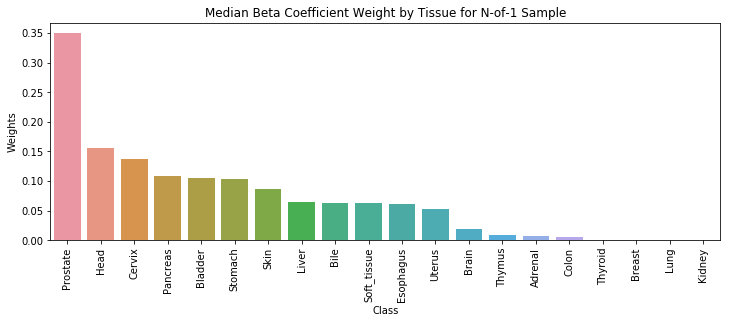

In [34]:
r.outlier.plot_weights(classes, t)

In [ ]:
error_map[500] = t['eps']

ppc = r.outlier.ppc_from_coefs(t, drug_genes, normal, 'tissue')
pvals[500] = r.outlier.posterior_predictive_pvals(sample, ppc)

 26%|██▌       | 130/500 [00:09<00:26, 13.80it/s]

## 1000 Genes

In [32]:
X, y, X_genes = prepare_sample(normal, sample, genes, n_genes=1000, class_col='tissue', n_comp=100)

In [33]:
m, t = r.outlier.run_model(y, X, 'tissue', 
                           training_genes=X_genes,
                           beta_func=pm.LogitNormal)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [19:39<00:00,  1.95draws/s] 
The number of effective samples is smaller than 25% for some parameters.


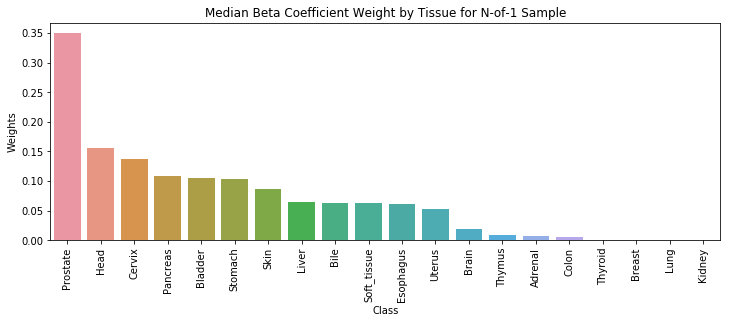

In [34]:
r.outlier.plot_weights(classes, t)

In [ ]:
error_map[1000] = t['eps']

ppc = r.outlier.ppc_from_coefs(t, drug_genes, normal, 'tissue')
pvals[1000] = r.outlier.posterior_predictive_pvals(sample, ppc)

 26%|██▌       | 130/500 [00:09<00:26, 13.80it/s]

# Plot